In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import shap

In [2]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('./train_test_data.csv')
data

GP_HOME  W_PCT_HOME  AST_PCT_HOME  OREB_PCT_HOME  DREB_PCT_HOME  \
0        71.0       0.803         0.706          0.270          0.713   
1        72.0       0.806         0.708          0.270          0.713   
2        73.0       0.699         0.629          0.281          0.719   
3        73.0       0.781         0.608          0.280          0.732   
4        76.0       0.816         0.708          0.272          0.709   
...       ...         ...           ...            ...            ...   
6964     52.0       0.481         0.572          0.232          0.735   
6965      6.0       0.500         0.600          0.282          0.730   
6966     37.0       0.622         0.610          0.240          0.704   
6967     70.0       0.686         0.617          0.257          0.720   
6968     71.0       0.479         0.572          0.239          0.738   

      REB_PCT_HOME  TM_TOV_PCT_HOME  EFG_PCT_HOME  TS_PCT_HOME  PIE_HOME  \
0            0.505            0.146         0.562        0.596     0.580   
1            0.505            0.146         0.561        0.596     0.580   
2            0.501            0.150         0.550        0.587     0.523   
3            0.512            0.139         0.527        0.568     0.557   
4            0.504            0.146         0.562        0.596     0.579   
...            ...              ...           ...          ...       ...   
6964         0.491            0.135         0.553        0.591     0.505   
6965         0.498            0.136         0.512        0.565     0.496   
6966         0.479            0.144         0.553        0.595     0.519   
6967         0.496            0.137         0.564        0.609     0.529   
6968         0.496            0.136         0.550        0.588     0.510   

     SEASON_YEAR   GAME_DATE  elo_HOME  DAYS_REST_HOME  W_PCT_L10_HOME  \
0        2016-17  2017-03-24   1745.60             3.0             0.7   
1        2016-17  2017-03-26   1746.81             2.0             0.7   
2        2016-17  2017-03-28   1637.66             2.0             0.7   
3        2016-17  2017-03-29   1711.82             2.0             0.7   
4        2016-17  2017-04-02   1774.58             2.0             1.0   
...          ...         ...       ...             ...             ...   
6964     2022-23  2023-02-06   1509.36             2.0             0.6   
6965     2022-23  2022-10-29   1459.58             1.0             0.5   
6966     2022-23  2023-01-06   1607.37             2.0             0.8   
6967     2022-23  2023-03-20   1678.61             2.0             0.9   
6968     2022-23  2023-03-22   1536.98             2.0             0.6   

      AST_PCT_L10_HOME  OREB_PCT_L10_HOME  DREB_PCT_L10_HOME  \
0                0.679              0.281              0.690   
1                0.712              0.284              0.701   
2                0.610              0.253              0.750   
3                0.638              0.297              0.703   
4                0.731              0.282              0.678   
...                ...                ...                ...   
6964             0.591              0.236              0.723   
6965             0.600              0.282              0.730   
6966             0.611              0.254              0.699   
6967             0.610              0.279              0.756   
6968             0.595              0.253              0.708   

      REB_PCT_L10_HOME  TM_TOV_PCT_L10_HOME  EFG_PCT_L10_HOME  \
0                0.495                0.150             0.541   
1                0.503                0.155             0.543   
2                0.499                0.138             0.556   
3                0.506                0.153             0.531   
4                0.503                0.157             0.580   
...                ...                  ...               ...   
6964             0.496                0.136             0.565   
6965             0.498                

In [3]:
def dataset_filters(df, min_games_played, seasons=None):
    df = df[(df['GP_HOME'] >= min_games_played) & (df['GP_AWAY'] >= min_games_played)]
    if seasons:
        df = df[df['SEASON_YEAR'].isin(seasons)]
    return df

In [4]:
data = dataset_filters(data, 10)

In [5]:
data.drop(columns=['SEASON_YEAR', 'GAME_DATE', 'GP_HOME', 'GP_AWAY'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
X = data.drop(['home_cover_spread'], axis=1)
y = data['home_cover_spread']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, random_state=24, test_size=0.25, stratify=y)

In [25]:
log_regressor = LogisticRegression(random_state=24)
scalers = [MinMaxScaler()]
def create_pipeline_gb(model, scaler):
    grid_results = []
    for scaler_ in scaler:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
        param_grid = [
            {
                'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['saga'],
                'classifier__l1_ratio': [0.15, 0.30, 0.5]
            },
            {
                'classifier__penalty': ['l1', 'l2'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['liblinear']
            },
            {
                'classifier__penalty': ['l2'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['lbfgs', 'newton-cg', 'newton_cholesky', 'sag']
            }
        ]
        pipeline = Pipeline([
            ('scaler', scaler_), ('classifier', model)
        ])
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring=('f1_weighted'), verbose=4)
        grid_search.fit(X_trainval, y_trainval)
        grid_results.append(grid_search)
    return grid_results

log_regressor_grid = create_pipeline_gb(log_regressor, scalers)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.1s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__

The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.3s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.3s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.3s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.2s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.2s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.3s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.2s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.3s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.1s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.1s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.418 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.418 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.470 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.448 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.412 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.421 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=50

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__m

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.447 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.350 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.2s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.2s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.2s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.1s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.479 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.1s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.474 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.472 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.473 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.478 total time=   0.1s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.1s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.2s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_rati

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.4s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.4s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.4s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.4s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.3s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.4s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.4s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.3s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.3s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.3s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.1s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.2s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.2s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.476 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.3s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.475 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.1s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.1s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.1s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.476 total time=   0.1s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.3s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.2s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__p

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__pen

The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.3s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.5s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   1.5s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.6s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   2.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.3s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.2s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalt

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=

The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.3s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.5s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   1.5s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.6s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   2.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.3s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   0.3s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.2s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalt

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=

The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.3s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.3s


The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.3s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.1s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.5s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   1.5s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   1.6s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.9s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.485 total time=   2.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.9s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.4s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.5s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.4s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.481 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.6s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.5s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.6s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, c

The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.1s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ra

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.1s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.1s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.2s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.3s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.2s


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.2s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.2s


The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.494 total time=   0.1s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.483 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.1s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__pen

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.482 total time=   0.3s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.2s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.3s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   1.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.473 total time=   0.7s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.3s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.3s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.473 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.2s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.496 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.2s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.1s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.1s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.1s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.482 total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.474 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.3s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, c

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.490 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.493 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.491 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.5, c

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.503 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 1/5] END classif

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.494 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.495 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.482 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.502 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.501 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.503 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.492 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.491 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.490 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 5/5

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END cl

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.495 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.486 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.507 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.490 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END clas

The max_iter was reached which means the coef_ did not converge


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.0001;, score=0.492 total time=   0.1s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.0001;, score=0.493 total time=   0.0s


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.0001;, score=0.512 total time=   0.1s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=sag, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fi

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.486 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.496 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=1, cla


450 fits failed out of a total of 6750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\

In [8]:
log_regressor_grid[0].best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=0.3, fit_intercept=False, l1_ratio=0.5,
                                    penalty='elasticnet', random_state=24,
                                    solver='saga', tol=0.001))])

In [26]:
predictions = log_regressor_grid[0].best_estimator_.predict(X_holdout)
print(classification_report(y_holdout, predictions))

              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55       782
         1.0       0.50      0.43      0.47       758

    accuracy                           0.51      1540
   macro avg       0.51      0.51      0.51      1540
weighted avg       0.51      0.51      0.51      1540



In [27]:
correct = 0
pred_count = 0
for index, result in enumerate(list(log_regressor_grid[0].best_estimator_.predict_proba(X_holdout))):
    if result[0] > 0.524 or result[1] > 0.524:
        pred_count = pred_count + 1
        if result[0] > result[1]:
            pred = 0
        else:
            pred = 1
        
        if pred == list(y_holdout)[index]:
            correct = correct + 1
            res = True
        else:
            res = False

        correct_perc = correct/pred_count
        
        print(f'index: {index} - Prediction {pred_count}: {pred} - actual: {list(y_holdout)[index]} - res: {res} - percentage: {correct_perc}')

index: 0 - Prediction 1: 0 - actual: 0.0 - res: True - percentage: 1.0
index: 1 - Prediction 2: 0 - actual: 0.0 - res: True - percentage: 1.0
index: 6 - Prediction 3: 1 - actual: 1.0 - res: True - percentage: 1.0
index: 13 - Prediction 4: 0 - actual: 1.0 - res: False - percentage: 0.75
index: 15 - Prediction 5: 0 - actual: 1.0 - res: False - percentage: 0.6
index: 16 - Prediction 6: 0 - actual: 0.0 - res: True - percentage: 0.6666666666666666
index: 18 - Prediction 7: 1 - actual: 0.0 - res: False - percentage: 0.5714285714285714
index: 21 - Prediction 8: 1 - actual: 1.0 - res: True - percentage: 0.625
index: 22 - Prediction 9: 1 - actual: 1.0 - res: True - percentage: 0.6666666666666666
index: 23 - Prediction 10: 0 - actual: 0.0 - res: True - percentage: 0.7
index: 28 - Prediction 11: 0 - actual: 1.0 - res: False - percentage: 0.6363636363636364
index: 29 - Prediction 12: 1 - actual: 1.0 - res: True - percentage: 0.6666666666666666
index: 37 - Prediction 13: 0 - actual: 0.0 - res: True

In [12]:
import pickle

with open('log_reg.pkl', 'wb') as files:
    pickle.dump(log_regressor_grid[0].best_estimator_, files)

In [13]:
model = pickle.load(open('log_reg.pkl', 'rb'))

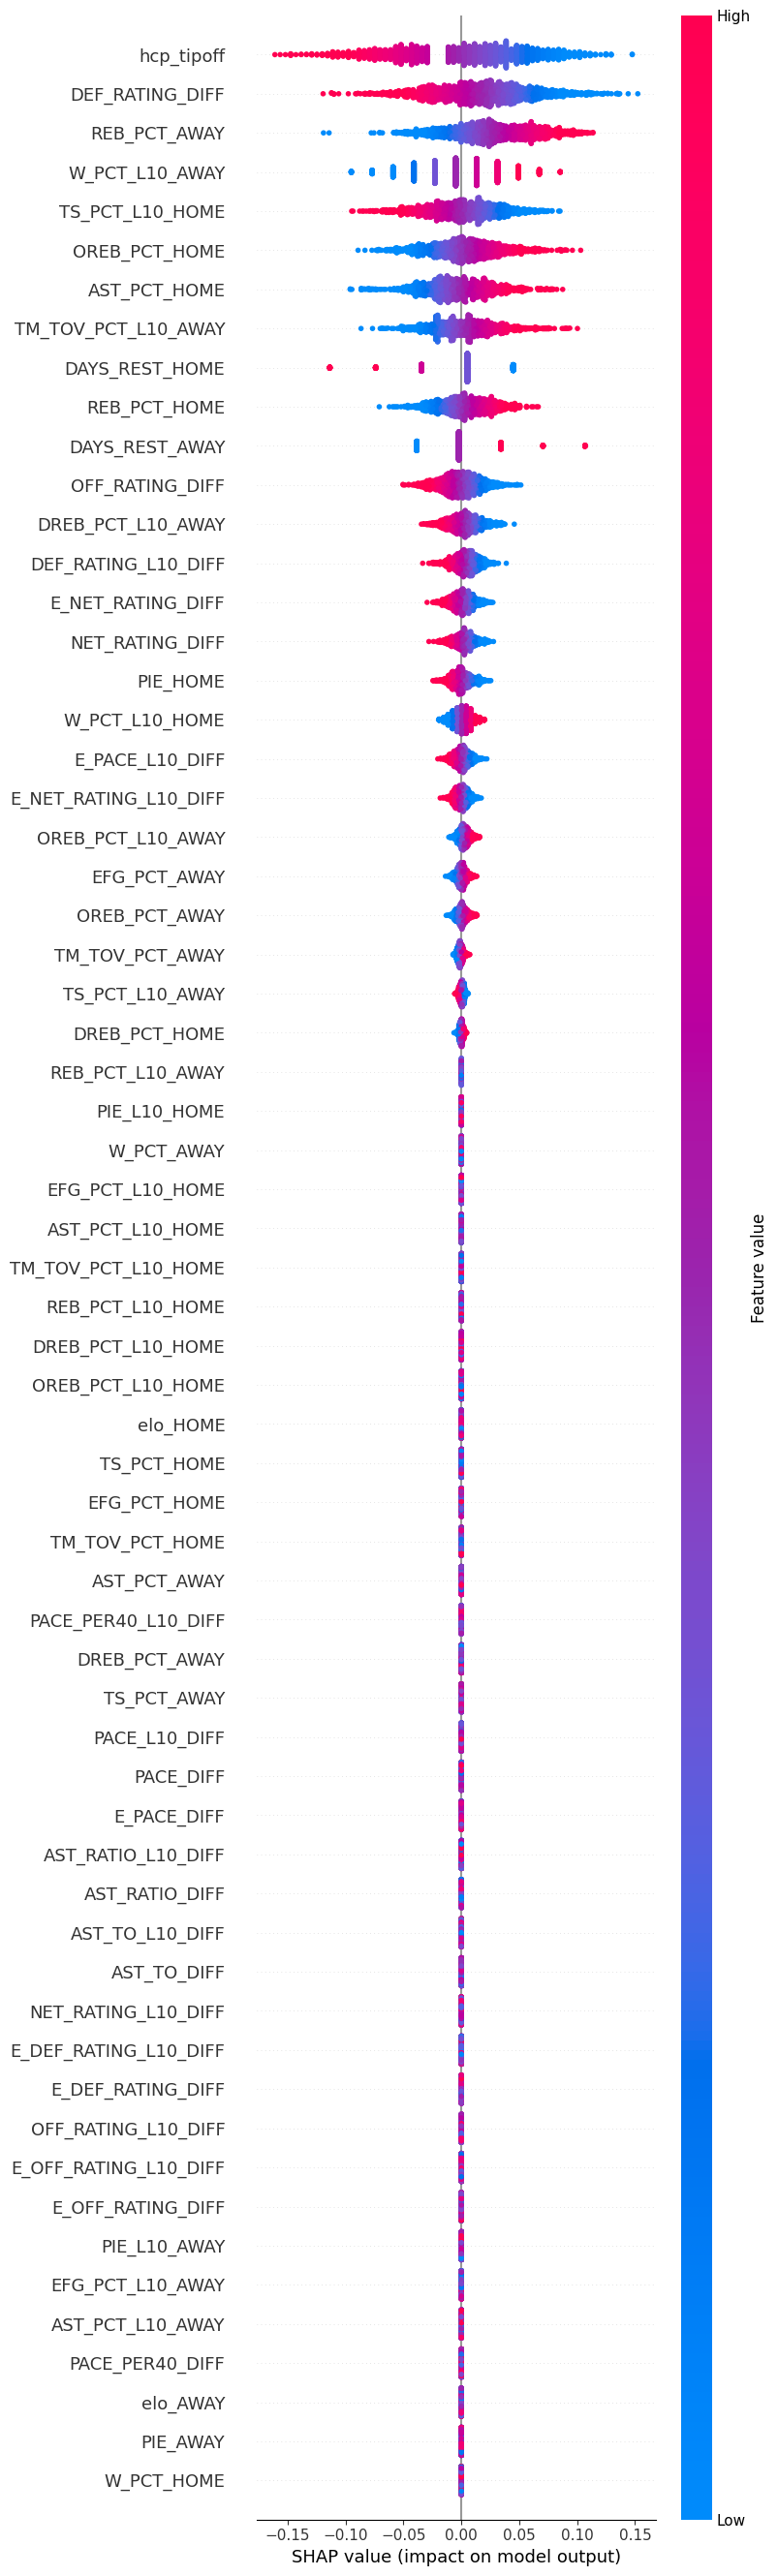

In [14]:
explainer = shap.Explainer(model.named_steps['classifier'], MinMaxScaler().fit_transform(X_trainval), feature_names=X_trainval.columns)
x_shap = MinMaxScaler().fit_transform(X_holdout)
shap_values = explainer.shap_values(x_shap)
shap.summary_plot(shap_values, MinMaxScaler().fit_transform(X_holdout), feature_names=X_trainval.columns, max_display=65)

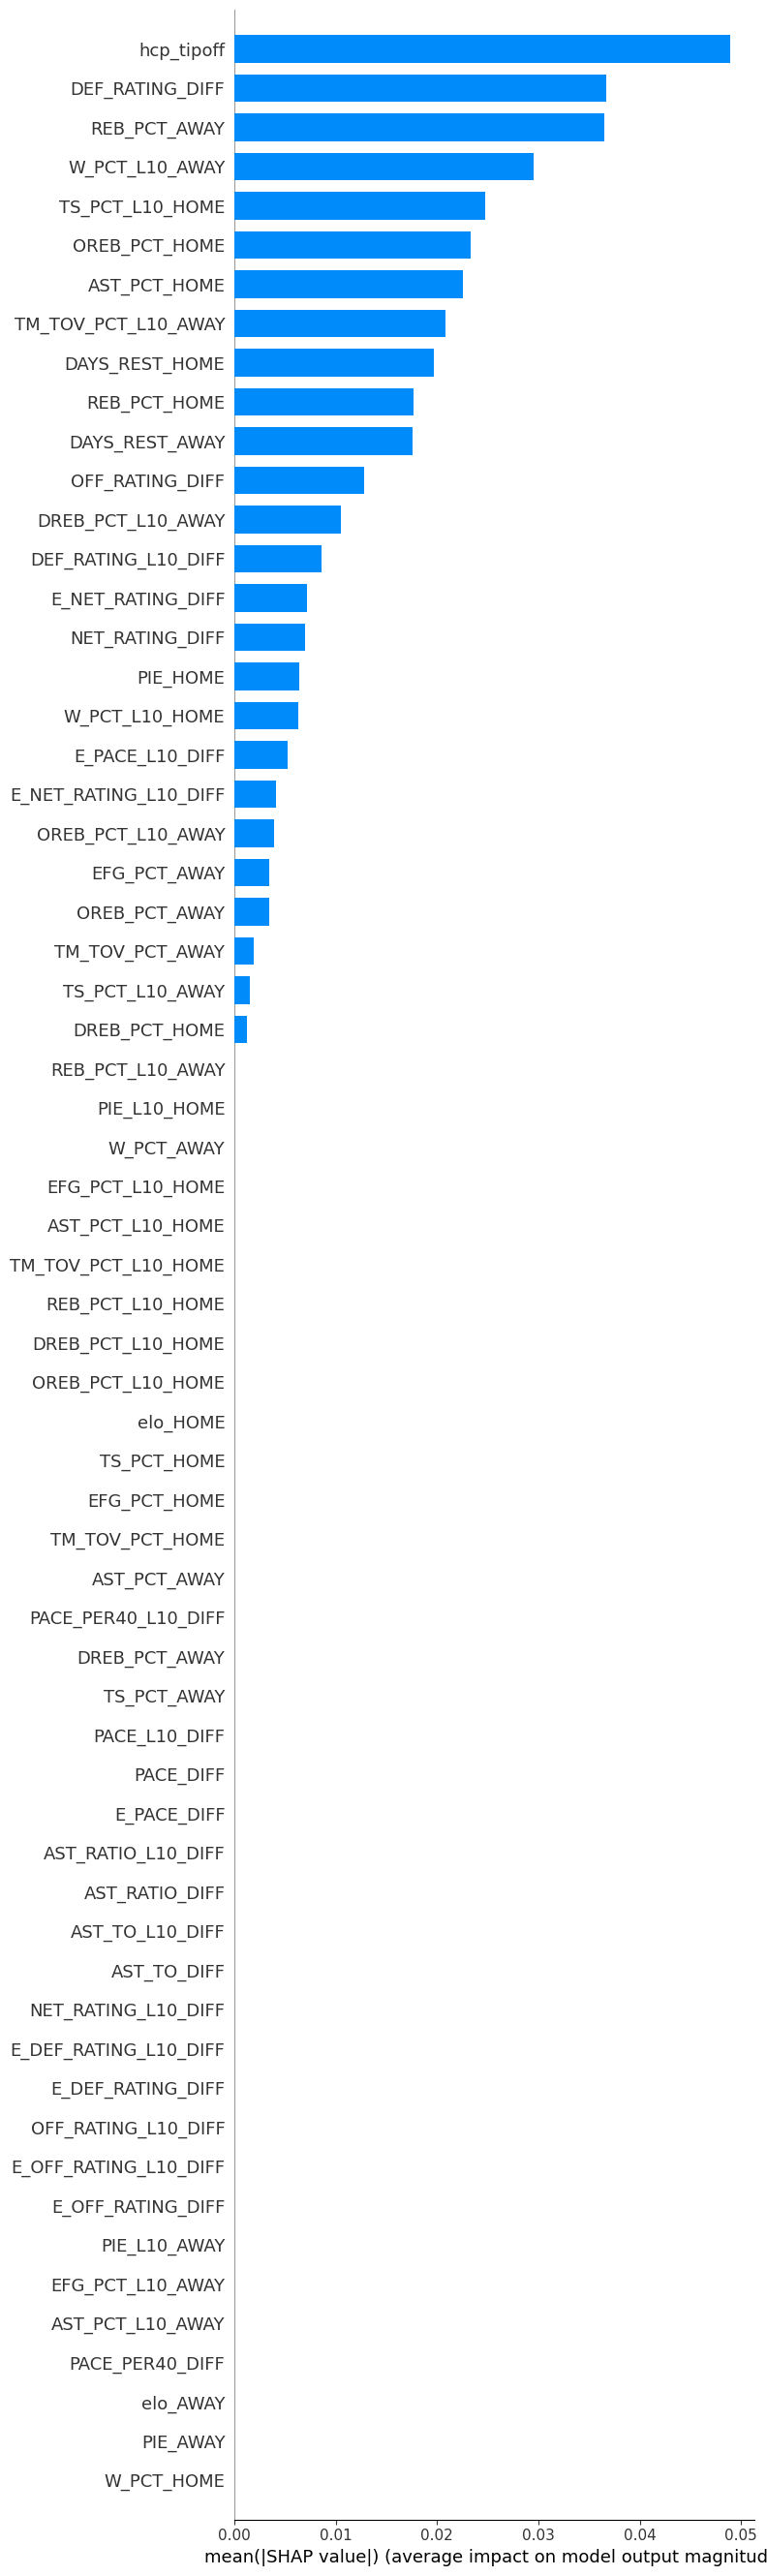

In [15]:
shap.summary_plot(shap_values, MinMaxScaler().fit_transform(X_holdout), feature_names=X_trainval.columns, plot_type='bar', max_display=65)

In [16]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[1], feature_names=X_trainval.columns)

In [17]:
from dice_ml import Model, Dice, Data
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib


In [18]:
model = Model(model=log_regressor_grid[0].best_estimator_, backend='sklearn')
dice_data = Data(
    dataframe=X_trainval.join(y_trainval),
    continuous_features=X.columns.tolist(),
    outcome_name='home_cover_spread')
dice_exp = Dice(dice_data, model, method='genetic')

In [19]:
cfes1 = dice_exp.generate_counterfactuals(
    X_holdout.iloc[[0]],
    total_CFs=2,
    desired_class="opposite"
)
cfes1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Query instance (original outcome : 0.0)


W_PCT_HOME  AST_PCT_HOME  OREB_PCT_HOME  DREB_PCT_HOME  REB_PCT_HOME  \
0       0.338         0.606          0.277          0.717         0.491   

   TM_TOV_PCT_HOME  EFG_PCT_HOME  TS_PCT_HOME  PIE_HOME     elo_HOME  \
0            0.136         0.515        0.549     0.475  1414.640015   

   DAYS_REST_HOME  W_PCT_L10_HOME  AST_PCT_L10_HOME  OREB_PCT_L10_HOME  \
0             3.0             0.5             0.645              0.252   

   DREB_PCT_L10_HOME  REB_PCT_L10_HOME  TM_TOV_PCT_L10_HOME  EFG_PCT_L10_HOME  \
0              0.715             0.485                0.142             0.529   

   TS_PCT_L10_HOME  PIE_L10_HOME  W_PCT_AWAY  AST_PCT_AWAY  OREB_PCT_AWAY  \
0             0.56         0.491       0.474         0.577          0.241   

   DREB_PCT_AWAY  REB_PCT_AWAY  TM_TOV_PCT_AWAY  EFG_PCT_AWAY  TS_PCT_AWAY  \
0          0.736         0.496            0.137         0.552        0.589   

   PIE_AWAY     elo_AWAY  DAYS_REST_AWAY  W_PCT_L10_AWAY  AST_PCT_L10_AWAY  \
0     0.509  1527.650024             2.0             0.6             0.621   

   OREB_PCT_L10_AWAY  DREB_PCT_L10_AWAY  REB_PCT_L10_AWAY  \
0              0.264              0.717             0.495   

   TM_TOV_PCT_L10_AWAY  EFG_PCT_L10_AWAY  TS_PCT_L10_AWAY  PIE_L10_AWAY  \
0                 0.14             0.566            0.598         0.516   

   hcp_tipoff  E_OFF_RATING_DIFF  E_OFF_RATING_L10_DIFF  OFF_RATING_DIFF  \
0        11.5               -4.6                   -7.0             -4.1   

   OFF_RATING_L10_DIFF  E_DEF_RATING_DIFF  E_DEF_RATING_L10_DIFF  \
0                 -6.6                2.5                    2.2   

   DEF_RATING_DIFF  DEF_RATING_L10_DIFF  E_NET_RATING_DIFF  \
0              2.6                  0.4               -7.0   

   E_NET_RATING_L10_DIFF  NET_RATING_DIFF  NET_RATING_L10_DIFF  AST_TO_DIFF  \
0                   -9.1             -6.7                 -7.0         0.03   

   AST_TO_L10_DIFF  AST_RATIO_DIFF  AST_RATIO_L10_DIFF  E_PACE_DIFF  \
0            -0.08            -0.3                -0.4          2.7   

   E_PACE_L10_DIFF  PACE_DIFF  PACE_L10_DIFF  PACE_PER40_DIFF  \
0              4.6       2.43           5.14             2.02   

   PACE_PER40_L10_DIFF  home_cover_spread  
0                 4.28                0.0


Diverse Counterfactual set (new outcome: 1.0)


W_PCT_HOME AST_PCT_HOME OREB_PCT_HOME DREB_PCT_HOME REB_PCT_HOME  \
0        0.5        0.641          0.29          0.69          0.5   
0        0.4        0.572         0.296         0.732          0.5   

  TM_TOV_PCT_HOME EFG_PCT_HOME TS_PCT_HOME PIE_HOME elo_HOME DAYS_REST_HOME  \
0            0.15        0.536       0.575    0.484        -            1.0   
0            0.16        0.512       0.548    0.499        -            2.0   

  W_PCT_L10_HOME AST_PCT_L10_HOME OREB_PCT_L10_HOME DREB_PCT_L10_HOME  \
0            0.1            0.603             0.321             0.679   
0            0.3            0.606             0.274             0.741   

  REB_PCT_L10_HOME TM_TOV_PCT_L10_HOME EFG_PCT_L10_HOME TS_PCT_L10_HOME  \
0            0.492               0.163            0.518               -   
0            0.505               0.145            0.508           0.543   

  PIE_L10_HOME W_PCT_AWAY AST_PCT_AWAY OREB_PCT_AWAY DREB_PCT_AWAY  \
0        0.437        0.6        0.623          0.26          0.74   
0        0.487        0.6            -         0.235          0.72   

  REB_PCT_AWAY TM_TOV_PCT_AWAY EFG_PCT_AWAY TS_PCT_AWAY PIE_AWAY elo_AWAY  \
0          0.5           0.139         0.57       0.607    0.515        -   
0        0.479           0.141        0.532       0.571      0.5        -   

  DAYS_REST_AWAY W_PCT_L10_AWAY AST_PCT_L10_AWAY OREB_PCT_L10_AWAY  \
0              -            0.7            0.606             0.271   
0              -            0.7            0.598             0.241   

  DREB_PCT_L10_AWAY REB_PCT_L10_AWAY TM_TOV_PCT_L10_AWAY EFG_PCT_L10_AWAY  \
0             0.716            0.504               0.131            0.586   
0             0.698            0.479               0.145            0.526   

  TS_PCT_L10_AWAY PIE_L10_AWAY hcp_tipoff E_OFF_RATING_DIFF  \
0           0.621        0.547        1.5              -6.0   
0           0.569        0.519       -1.5              -3.1   

  E_OFF_RATING_L10_DIFF OFF_RATING_DIFF OFF_RATING_L10_DIFF E_DEF_RATING_DIFF  \
0                 -13.5            -4.6               -11.4               1.0   
0                  -3.6            -2.1                -2.2              -0.2   

  E_DEF_RATING_L10_DIFF DEF_RATING_DIFF DEF_RATING_L10_DIFF E_NET_RATING_DIFF  \
0                   7.4             0.4                 6.1                 -   
0                   7.5            -0.9                 6.2              -2.8   

  E_NET_RATING_L10_DIFF NET_RATING_DIFF NET_RATING_L10_DIFF AST_TO_DIFF  \
0                 -20.8            -5.1               -17.5       -0.18   
0                 -11.1            -1.2                -8.5       -0.15   

  AST_TO_L10_DIFF AST_RATIO_DIFF AST_RATIO_L10_DIFF E_PACE_DIFF  \
0            -0.6           -0.8               -2.4         0.9   
0             0.1              -                0.5         1.0   

  E_PACE_L10_DIFF PACE_DIFF PACE_L10_DIFF PACE_PER40_DIFF PACE_PER40_L10_DIFF  \
0             4.9       0.5          4.43            0.44                3.69   
0             1.8       0.9          1.75            0.71                1.46   

  home_cover_spread  
0               1.0  
0               1.0

In [20]:
local_feat_importance = dice_exp.local_feature_importance(X_holdout.iloc[[0]], total_CFs=50)

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [21]:
local_feat_importance

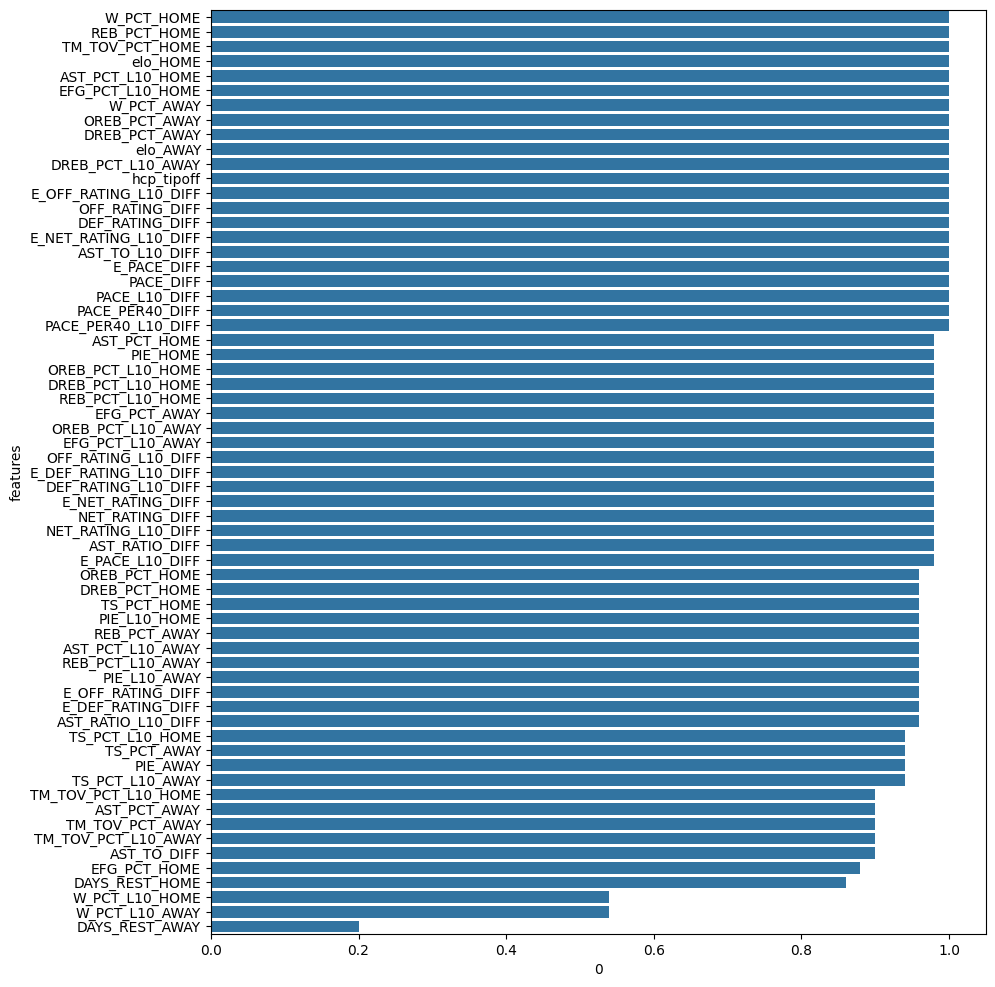

In [22]:
local_importance = pd.DataFrame(pd.Series(local_feat_importance.local_importance[0])).reset_index(names='features').iloc[0:90]
plt.figure(figsize=(10, 12))
sns.barplot(data=local_importance, y='features', x=0)
plt.show()

In [23]:
global_feat_importance = dice_exp.global_feature_importance(X_trainval[y_trainval==1].iloc[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


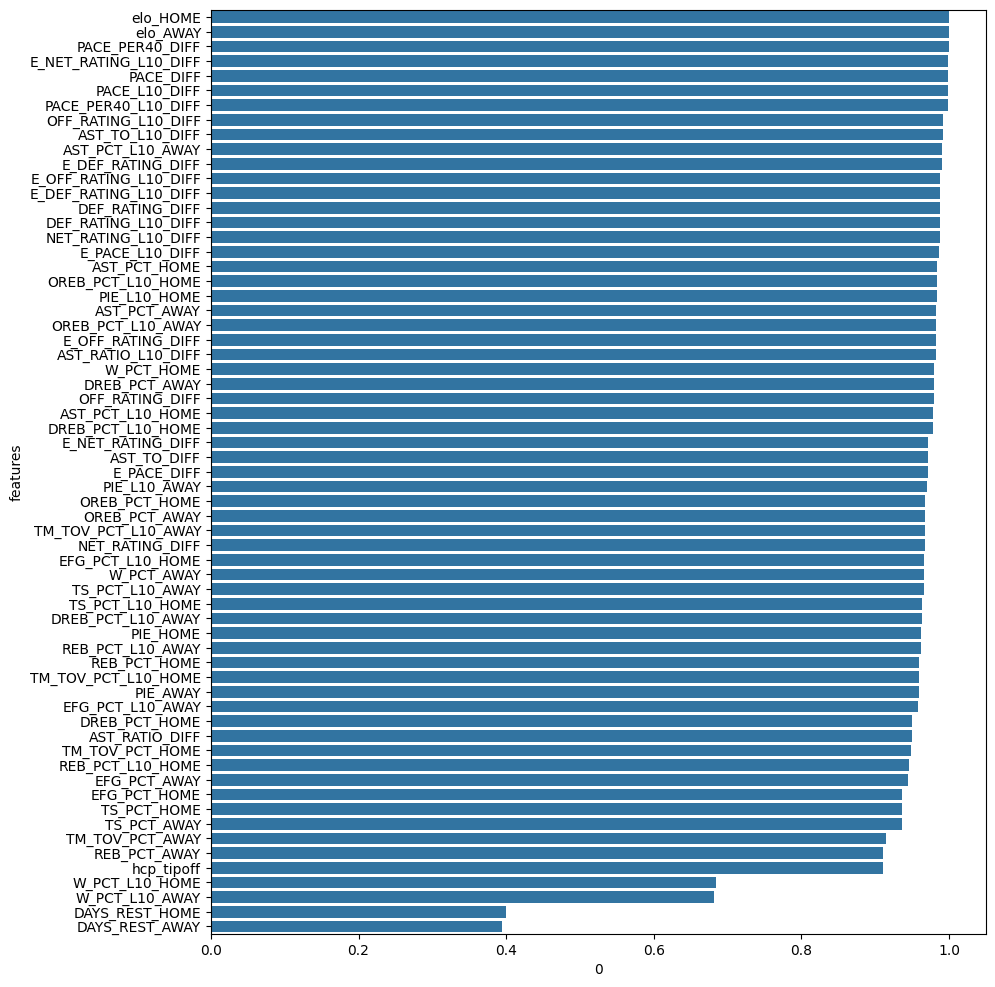

In [24]:
global_importance = pd.DataFrame(pd.Series(global_feat_importance.summary_importance)).reset_index(names='features').iloc[0:70]
plt.figure(figsize=(10, 12))
sns.barplot(data=global_importance, y='features', x=0)
plt.show()

**problems**:
- couldn't tune a model that gets better than 51-52% consitently. found this project https://github.com/NBA-Betting/NBA_Betting that's similar to what i'm doing, highest model right now is at 52.1% with a target of 52.4% (profitability). Trained several models - gbm, xgboost, linearsvc, sgdclassifier, log regression, lgbm
- potential workaround, use predict_proba method to only explictly predict games that the model predicts to have a prediction probability of greater that 0.524 on either side:
- using this, was able to get 0.539 accuracy on 556 predictions over 1537 holdout data points: *index: 1536 - Prediction 556: 0 - actual: 1.0 - res: False - percentage: 0.539568345323741*
- possible reason for this when connecting to the narrative: fans can't watch every single nba game, time and resource is limited, might as well pick matches that are forecasted to be worth watching, for tv broadcasters, only 1 game for a timeslot and a lot of games happen simultaneously so it's important to pick out which games to show for better viewership

-loss of viewership vs betting loss


**narrative change**:
- maximizing entertainment value by predicting which underdogs are expected to overperform vs expectations resulting in games that are closer/more exciting than expected or an upset is more likely
- possible stakeholders aside from team managers (team construction, player drafting, and acquisition): fans, possibly tv broadcasters, the league itself. A more exciting product can draw in more fans, in turn more revenue

**next steps**:

Modeling: (Monday - Tuesday)
- remove features shown from coef attribute that do no contribute to the model
- 1. retrain model to check if performance gets better, if not, keep current logistic regression pipeline as the final model

App: (1, 2, 3 hopefully by Thursday, 4 by Friday)
- start streamlit app and slides: 
- 1. tab for predictions for upcoming games with option to view local feature importance for predictions, for use of fans, tv broadcasters (essentially the gambling aspect veiled with 'entertainment value') .
- 2. tab for predictions from previous games for the current season to see how the model has done
- For 1 and 2, would need to get data for the current season using the api, scrape data from sbr 
- 3. tab for global feature importance - can be useful for team stakeholders in buidling teams for the future by drafting/acquiring players that better help teams overperform against expectations. 
- 4. tab for explanation regarding the process and thought behind the project so panelists can read along while it's being presented or take a look after


**stretch goals**: (Ideally starting on Thursday) - what are metrics for regression problems? - root mean squared error - will penalize larger errors, mean absolute error
- train another model that predicts total game score (regression problem), can use the same dataset.
- thinking behind this is that more points == more exciting games (not necessarily but is often the case, specially for casual fans or people who might just be getting into viewing)
- incorporate this into tab 1 and 2 of the streamlit app

In [53]:
# retraining
best_classifier = log_regressor_grid[0].best_estimator_.named_steps['classifier']
coefs = list(best_classifier.coef_[0])
coefs

[0.0,
 0.18359075180962453,
 0.1923735052849915,
 0.011105872331728968,
 0.13739388558873486,
 0.0,
 0.0,
 0.0,
 -0.05002710448792146,
 0.0,
 -0.15850417697416228,
 0.0389548139971229,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.1800441670869115,
 0.0,
 0.0,
 0.0,
 0.02673866235990778,
 0.0,
 0.2328217262958266,
 0.014558923062367822,
 0.027081226783573244,
 0.0,
 0.0,
 0.0,
 0.14528373592733798,
 0.1804912826273481,
 0.0,
 0.02661279586731365,
 -0.08025093642653468,
 1.5357436192657693e-05,
 0.18699412538254614,
 0.0,
 -0.011735367575378663,
 0.0,
 -0.3087386370026987,
 0.0,
 0.0,
 -0.10192067799010882,
 0.0,
 0.0,
 0.0,
 -0.2719055732166064,
 -0.07223053059786581,
 -0.05689250106416812,
 -0.03549869518678041,
 -0.05583635287990269,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.042427922186546646,
 0.0,
 0.0,
 0.0,
 0.0]

In [54]:
features_X = list(X.columns)
features_X

['W_PCT_HOME',
 'AST_PCT_HOME',
 'OREB_PCT_HOME',
 'DREB_PCT_HOME',
 'REB_PCT_HOME',
 'TM_TOV_PCT_HOME',
 'EFG_PCT_HOME',
 'TS_PCT_HOME',
 'PIE_HOME',
 'elo_HOME',
 'DAYS_REST_HOME',
 'W_PCT_L10_HOME',
 'AST_PCT_L10_HOME',
 'OREB_PCT_L10_HOME',
 'DREB_PCT_L10_HOME',
 'REB_PCT_L10_HOME',
 'TM_TOV_PCT_L10_HOME',
 'EFG_PCT_L10_HOME',
 'TS_PCT_L10_HOME',
 'PIE_L10_HOME',
 'W_PCT_AWAY',
 'AST_PCT_AWAY',
 'OREB_PCT_AWAY',
 'DREB_PCT_AWAY',
 'REB_PCT_AWAY',
 'TM_TOV_PCT_AWAY',
 'EFG_PCT_AWAY',
 'TS_PCT_AWAY',
 'PIE_AWAY',
 'elo_AWAY',
 'DAYS_REST_AWAY',
 'W_PCT_L10_AWAY',
 'AST_PCT_L10_AWAY',
 'OREB_PCT_L10_AWAY',
 'DREB_PCT_L10_AWAY',
 'REB_PCT_L10_AWAY',
 'TM_TOV_PCT_L10_AWAY',
 'EFG_PCT_L10_AWAY',
 'TS_PCT_L10_AWAY',
 'PIE_L10_AWAY',
 'hcp_tipoff',
 'E_OFF_RATING_DIFF',
 'E_OFF_RATING_L10_DIFF',
 'OFF_RATING_DIFF',
 'OFF_RATING_L10_DIFF',
 'E_DEF_RATING_DIFF',
 'E_DEF_RATING_L10_DIFF',
 'DEF_RATING_DIFF',
 'DEF_RATING_L10_DIFF',
 'E_NET_RATING_DIFF',
 'E_NET_RATING_L10_DIFF',
 'NET_RATING_

In [55]:
feature_coefs = {}
features_keep = []
for idx, feature in enumerate(features_X):
    feature_coefs[feature] = coefs[idx]
    if coefs[idx] != 0:
        features_keep.append(feature)
    print(f'{feature}: {coefs[idx]}')

features_keep.append('home_cover_spread')
features_keep

W_PCT_HOME: 0.0
AST_PCT_HOME: 0.18359075180962453
OREB_PCT_HOME: 0.1923735052849915
DREB_PCT_HOME: 0.011105872331728968
REB_PCT_HOME: 0.13739388558873486
TM_TOV_PCT_HOME: 0.0
EFG_PCT_HOME: 0.0
TS_PCT_HOME: 0.0
PIE_HOME: -0.05002710448792146
elo_HOME: 0.0
DAYS_REST_HOME: -0.15850417697416228
W_PCT_L10_HOME: 0.0389548139971229
AST_PCT_L10_HOME: 0.0
OREB_PCT_L10_HOME: 0.0
DREB_PCT_L10_HOME: 0.0
REB_PCT_L10_HOME: 0.0
TM_TOV_PCT_L10_HOME: 0.0
EFG_PCT_L10_HOME: 0.0
TS_PCT_L10_HOME: -0.1800441670869115
PIE_L10_HOME: 0.0
W_PCT_AWAY: 0.0
AST_PCT_AWAY: 0.0
OREB_PCT_AWAY: 0.02673866235990778
DREB_PCT_AWAY: 0.0
REB_PCT_AWAY: 0.2328217262958266
TM_TOV_PCT_AWAY: 0.014558923062367822
EFG_PCT_AWAY: 0.027081226783573244
TS_PCT_AWAY: 0.0
PIE_AWAY: 0.0
elo_AWAY: 0.0
DAYS_REST_AWAY: 0.14528373592733798
W_PCT_L10_AWAY: 0.1804912826273481
AST_PCT_L10_AWAY: 0.0
OREB_PCT_L10_AWAY: 0.02661279586731365
DREB_PCT_L10_AWAY: -0.08025093642653468
REB_PCT_L10_AWAY: 1.5357436192657693e-05
TM_TOV_PCT_L10_AWAY: 0.186994

['AST_PCT_HOME',
 'OREB_PCT_HOME',
 'DREB_PCT_HOME',
 'REB_PCT_HOME',
 'PIE_HOME',
 'DAYS_REST_HOME',
 'W_PCT_L10_HOME',
 'TS_PCT_L10_HOME',
 'OREB_PCT_AWAY',
 'REB_PCT_AWAY',
 'TM_TOV_PCT_AWAY',
 'EFG_PCT_AWAY',
 'DAYS_REST_AWAY',
 'W_PCT_L10_AWAY',
 'OREB_PCT_L10_AWAY',
 'DREB_PCT_L10_AWAY',
 'REB_PCT_L10_AWAY',
 'TM_TOV_PCT_L10_AWAY',
 'TS_PCT_L10_AWAY',
 'hcp_tipoff',
 'OFF_RATING_DIFF',
 'DEF_RATING_DIFF',
 'DEF_RATING_L10_DIFF',
 'E_NET_RATING_DIFF',
 'E_NET_RATING_L10_DIFF',
 'NET_RATING_DIFF',
 'E_PACE_L10_DIFF',
 'home_cover_spread']

In [56]:
data_trimmed = data.copy(deep=True)
data_trimmed = data_trimmed[features_keep]
data_trimmed

AST_PCT_HOME  OREB_PCT_HOME  DREB_PCT_HOME  REB_PCT_HOME  PIE_HOME  \
0            0.706          0.270          0.713         0.505     0.580   
1            0.708          0.270          0.713         0.505     0.580   
2            0.629          0.281          0.719         0.501     0.523   
3            0.608          0.280          0.732         0.512     0.557   
4            0.708          0.272          0.709         0.504     0.579   
...            ...            ...            ...           ...       ...   
6963         0.630          0.308          0.703         0.496     0.455   
6964         0.572          0.232          0.735         0.491     0.505   
6966         0.610          0.240          0.704         0.479     0.519   
6967         0.617          0.257          0.720         0.496     0.529   
6968         0.572          0.239          0.738         0.496     0.510   

      DAYS_REST_HOME  W_PCT_L10_HOME  TS_PCT_L10_HOME  OREB_PCT_AWAY  \
0                3.0             0.7            0.569          0.261   
1                2.0             0.7            0.571          0.292   
2                2.0             0.7            0.594          0.270   
3                2.0             0.7            0.564          0.270   
4                2.0             1.0            0.606          0.287   
...              ...             ...              ...            ...   
6963             2.0             0.1            0.546          0.251   
6964             2.0             0.6            0.602          0.307   
6966             2.0             0.8            0.599          0.237   
6967             2.0             0.9            0.662          0.240   
6968             2.0             0.6            0.604          0.256   

      REB_PCT_AWAY  TM_TOV_PCT_AWAY  EFG_PCT_AWAY  DAYS_REST_AWAY  \
0            0.493            0.151         0.514             2.0   
1            0.506            0.136         0.490             3.0   
2            0.505            0.146         0.563             2.0   
3            0.505            0.147         0.563             1.0   
4            0.502            0.142         0.526             2.0   
...            ...              ...           ...             ...   
6963         0.487            0.142         0.558             2.0   
6964         0.496            0.151         0.531             3.0   
6966         0.491            0.137         0.547             2.0   
6967         0.497            0.137         0.551             2.0   
6968         0.497            0.138         0.562             2.0   

      W_PCT_L10_AWAY  OREB_PCT_L10_AWAY  DREB_PCT_L10_AWAY  REB_PCT_L10_AWAY  \
0                0.2              0.227              0.695             0.468   
1                0.4              0.288              0.740             0.501   
2                0.7              0.278              0.701             0.504   
3                0.8              0.278              0.698             0.505   
4                0.5              0.318              0.735             0.517   
...              ...                ...                ...               ...   
6963             0.8              0.272              0.727             0.503   
6964             0.1              0.326              0.728             0.512   
6966             0.6              0.229              0.720             0.487   
6967             0.6              0.261              0.699             0.496   
6968             0.8              0.276              0.760             0.538   

      TM_TOV_PCT_L10_AWAY  TS_PCT_L10_AWAY  hcp_tipoff  OFF_RATING_DIFF  \
0                   0.141            0.560       -18.5              7.8   
1                   0.135            0.533       -11.5              7.5   
2                   0.159            0.576        -1.5              0.2   
3                   0.156            0.586        -4.5             -3.5   
4                   0.135            0.554        -9.5         

In [57]:
X_trimmed = data_trimmed.drop(['home_cover_spread'], axis=1)
y_trimmed = data_trimmed['home_cover_spread']
(X_trainval_trimmed, X_holdout_trimmed, y_trainval_trimmed, y_holdout_trimmed) = train_test_split(X_trimmed, y_trimmed, random_state=24, test_size=0.25, stratify=y_trimmed)

In [58]:
log_regressor = LogisticRegression(random_state=24)
scalers = [MinMaxScaler()]
def create_pipeline_gb(model, scaler):
    grid_results = []
    for scaler_ in scaler:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
        param_grid = [
            {
                'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['saga'],
                'classifier__l1_ratio': [0.15, 0.30, 0.5]
            },
            {
                'classifier__penalty': ['l1', 'l2'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['liblinear']
            },
            {
                'classifier__penalty': ['l2'],
                'classifier__tol': [0.0001, 0.001, 0.1],
                'classifier__C': [0.5, 0.15, 0.3, 0.6, 1],
                'classifier__fit_intercept': [True, False],
                'classifier__max_iter': [100, 500, 1000],
                'classifier__solver': ['lbfgs', 'newton-cg', 'newton_cholesky', 'sag']
            }
        ]
        pipeline = Pipeline([
            ('scaler', scaler_), ('classifier', model)
        ])
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring=('f1_weighted'), verbose=4)
        grid_search.fit(X_trainval_trimmed, y_trainval_trimmed)
        grid_results.append(grid_search)
    return grid_results

log_regressor_grid_trimmed = create_pipeline_gb(log_regressor, scalers)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=5

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'ela

[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__m

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.527 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.527 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.527 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=5

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.494 total time=   0.0s
[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.528 total time=   0.0s
[CV 1/5] END classifier__C=0.5, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__ma

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.418 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.419 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.521 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.418 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.419 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.521 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.419 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.521 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.419 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.479 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.483 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.408 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.484 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.468 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.423 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.469 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.510 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__m

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.476 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.459 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.520 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.476 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.459 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.520 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.486 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.520 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.484 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.476 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.459 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.372 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'ela

[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.528 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.476 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.459 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.528 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.463 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.369 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.341 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.476 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.459 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.521 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.528 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.477 total time=   0.0s
[CV 5/5] END classifier__C=0.15, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.15, classifier__fit_intercept=False, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ra

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=50

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_r

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.478 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.518 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'ela

[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=True, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.494 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.520 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.520 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.471 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'ela

[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.493 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.480 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.516 total time=   0.0s
[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 5/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.522 total time=   0.0s
[CV 1/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.3, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=50

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=50

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=5

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'ela

[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.515 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.505 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.497 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.485 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=10

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.509 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.490 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'ela

[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.513 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_it

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=5

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.512 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.528 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.481 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_i

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.518 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.480 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.483 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_ite

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.514 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=False, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=100, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.516 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__pe

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__pe

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.510 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__pena

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__pe

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.516 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.516 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.504 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.518 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.516 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.493 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, cla

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.534 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.532 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, cl

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.511 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.532 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.497 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.534 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.15, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_rat

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.529 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.507 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.532 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, c

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.3, classifier__max_iter=1000, classifier__

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classif

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.509 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifie

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.502 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.505 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5,

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.0001;, score=0.531 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, class

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.532 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.508 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__p

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.487 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.502 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.492 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penal

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.496 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.513 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l1, classifier__solver=saga, classifier__tol=0.001;, score=0.498 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, clas

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.512 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.488 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.0001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, 

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.506 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.001;, score=0.526 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__tol=0.1;, score=0.503 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classi

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


[CV 4/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.499 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.0001;, score=0.533 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.501 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.5, classifier__max_iter=1000, classifier__penalty=elasticnet, classifier__solver=saga, classifier__tol=0.001;, score=0.491 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=False, classifier__l1_ratio=0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.517 total time=   0.0s
[CV 1/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.511 total time=   0.0s
[CV 4/5] END classifier__C=0.6, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.489 total time=   0.0s
[CV 5/5] END classifier_

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.0001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.500 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.508 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.487 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 5/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.001;, score=0.523 total time=   0.0s
[CV 1/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.499 total time=   0.0s
[CV 2/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.495 total time=   0.0s
[CV 3/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.507 total time=   0.0s
[CV 4/5] END classifier__C=1, classifier__fit_intercept=True, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs, classifier__tol=0.1;, score=0.490 total time=   0.0s
[CV 5/5] END classifier__C=1, classifier__f


450 fits failed out of a total of 6750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\63917\anaconda3\envs\nba-model\lib\site-packages\sklearn\

In [59]:
log_regressor_grid_trimmed[0].best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=0.15, fit_intercept=False,
                                    random_state=24, solver='sag', tol=0.1))])

In [60]:
predictions_trimmed = log_regressor_grid_trimmed[0].best_estimator_.predict(X_holdout_trimmed)
print(classification_report(y_holdout_trimmed, predictions_trimmed))

              precision    recall  f1-score   support

         0.0       0.53      0.59      0.56       782
         1.0       0.52      0.45      0.48       758

    accuracy                           0.52      1540
   macro avg       0.52      0.52      0.52      1540
weighted avg       0.52      0.52      0.52      1540



In [70]:
correct = 0
pred_count = 0
for index, result in enumerate(list(log_regressor_grid_trimmed[0].best_estimator_.predict_proba(X_holdout_trimmed))):
    if result[0] > 0.524 or result[1] > 0.524:
        pred_count = pred_count + 1
        if result[0] > result[1]:
            pred = 0
        else:
            pred = 1
        
        if pred == list(y_holdout_trimmed)[index]:
            correct = correct + 1
            res = True
        else:
            res = False

        correct_perc = correct/pred_count
        
        print(f'index: {index} - Prediction {pred_count}: {pred} - actual: {list(y_holdout)[index]} - res: {res} - percentage: {correct_perc}')

index: 0 - Prediction 1: 0 - actual: 0.0 - res: True - percentage: 1.0
index: 1 - Prediction 2: 0 - actual: 0.0 - res: True - percentage: 1.0
index: 5 - Prediction 3: 1 - actual: 0.0 - res: False - percentage: 0.6666666666666666
index: 6 - Prediction 4: 1 - actual: 1.0 - res: True - percentage: 0.75
index: 8 - Prediction 5: 0 - actual: 1.0 - res: False - percentage: 0.6
index: 13 - Prediction 6: 0 - actual: 1.0 - res: False - percentage: 0.5
index: 15 - Prediction 7: 0 - actual: 1.0 - res: False - percentage: 0.42857142857142855
index: 16 - Prediction 8: 0 - actual: 0.0 - res: True - percentage: 0.5
index: 18 - Prediction 9: 1 - actual: 0.0 - res: False - percentage: 0.4444444444444444
index: 19 - Prediction 10: 0 - actual: 1.0 - res: False - percentage: 0.4
index: 21 - Prediction 11: 1 - actual: 1.0 - res: True - percentage: 0.45454545454545453
index: 22 - Prediction 12: 1 - actual: 1.0 - res: True - percentage: 0.5
index: 23 - Prediction 13: 0 - actual: 0.0 - res: True - percentage: 